In [1]:
%pylab notebook
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import rasterio
from datacube.storage.storage import write_dataset_to_netcdf

Populating the interactive namespace from numpy and matplotlib


In [2]:
dc = datacube.Datacube(app='dc-netCDF export example')

In [3]:
#Define temporal range
start_of_epoch = '2010-01-01'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['red', 'nir']

#Define sensors of interest, # out sensors that aren't relevant for the time period
sensors = ['ls8','ls7', 'ls5'] 
query = {'time': (start_of_epoch, end_of_epoch),}

#The example shown here is for the East Alligator river in the Northern Territory
lat_max = -15.44
lat_min = -15.54
lon_max = 125.1
lon_min = 124.92

query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

## PQ and Index preparation


In [4]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensors[0]+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [5]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [6]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    if bool(sensor_nbar):
        sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
        #grab the projection info before masking/sorting
        crs = sensor_nbar.crs
        crswkt = sensor_nbar.crs.wkt
        affine = sensor_nbar.affine
        #This line is to make sure there's PQ to go with the NBAR
        #sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
        #Apply the PQ masks to the NBAR
        cloud_free = masking.make_mask(sensor_pq, **mask_components)
        good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
        sensor_nbar = sensor_nbar.where(good_data)
        sensor_clean[sensor] = sensor_nbar

In [9]:
#Concatenate data from different sensors together and sort so that observations are sorted by time rather
# than sensor
nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

In [10]:
#Calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
#Calculate annual average NDVI values
annual_ndvi = ndvi.groupby('time.year')
annual_mean = annual_ndvi.mean(dim = 'time') #The .mean argument here can be replaced by max, min, median
#but you'll need to update the code below here accordingly
ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

In [11]:
#Create colour map for NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' ,  '#2eb82e',  '#006600'])
ndvi_bounds = [-1, 0, 0.1,  0.4,  0.6, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

## Plotting an image, view the transect and select a location to retrieve a time series

<IPython.core.display.Javascript object>


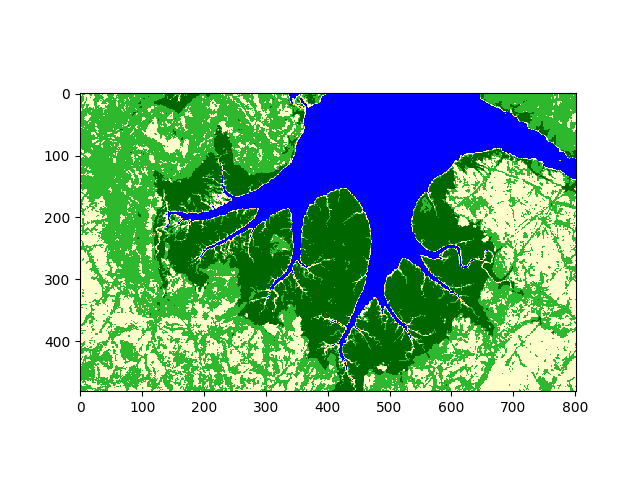

In [12]:
fig = plt.figure()
#Plot the mean NDVI values for a year of interest (yoi)
#Dark green = high amounts of green vegetation through to yellows and oranges being lower amounts of vegetation,
#Blue indicates a NDVI < 0 typically associated with water
yoi = 2011

#plt.title('Average annual NDVI for '+str(yoi))
arr_yoi = annual_mean.sel(year =yoi)
plt.imshow(arr_yoi, cmap = ndvi_cmap, norm = ndvi_norm)

<IPython.core.display.Javascript object>


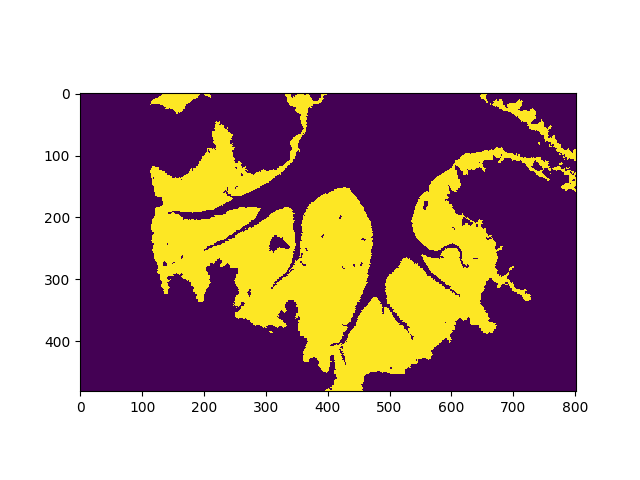

In [13]:
# Read in the ALOS shape file of mangrove extent and convert it to raster image to be same size as NDVI diff LL image

import ogr, gdal, osr

# Define pixel size and NoData value of new raster
xres = nbar_clean.attrs['affine'][0]
yres = nbar_clean.attrs['affine'][4]
NoData_value = -9999

# Filename of shape file
#The GMW file is available globally, but a locally pertinent region of the GMW (Global Mangrove Watch) file
#would need to be spliced in here
vector_fn = '/g/data/r78/cjt599/GMW_Australia_MangroveExtent2010_AlbersEA_shp.shp'

# set the geotransform properties
xcoord = arr_yoi.coords['x'].min()
ycoord = arr_yoi.coords['y'].max()
geotransform = (xcoord - (xres*0.5), xres, 0, ycoord + (yres*0.5), 0, yres)

# Open the data source and read in the extent
source_ds = ogr.Open(vector_fn)
source_layer = source_ds.GetLayer()
source_srs = source_layer.GetSpatialRef()
vx_min, vx_max, vy_min, vy_max = source_layer.GetExtent() # this is extent of Australia

# Create the destination extent
yt,xt = arr_yoi.shape # to be the same size as NDVI diff image

# set up mask image including projection
target_ds = gdal.GetDriverByName('MEM').Create('', xt, yt, gdal.GDT_Byte)
target_ds.SetGeoTransform(geotransform) # this is the same as the NDVI diff LL geoTIFF
albers = osr.SpatialReference() # establish encoding
albers.ImportFromEPSG(3577) # to projection
target_ds.SetProjection(albers.ExportToWkt()) # export coords to file
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(NoData_value)

# rasterise
gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])
#target_ds.FlushCache() # use this line to write to GeoTIFF file
#target_ds = None # use this line to write to GeoTIFF file

# Read as array and apply ALOS mask to reprojected NDVI diff
ALOS_array = band.ReadAsArray()

fig = plt.figure()
plt.imshow(ALOS_array)

In [14]:
#Set the NDVI threshold using ndvi_thresh, as established with reference to Karen Danaher's mapping of mangrove
#communities on the Alligator River (NT) matched between Rapid Eye data for 2010 and the Landsat mean annual NDVI 
#for 2010
ndvi_thresh1 = 0.4
ndvi_thresh2 = 0.6
mangrove_multi = annual_mean.where(ALOS_array == 1)
mangrove_area = mangrove_multi>ndvi_thresh1
closed_mangrove_area = mangrove_multi>ndvi_thresh2

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


<IPython.core.display.Javascript object>


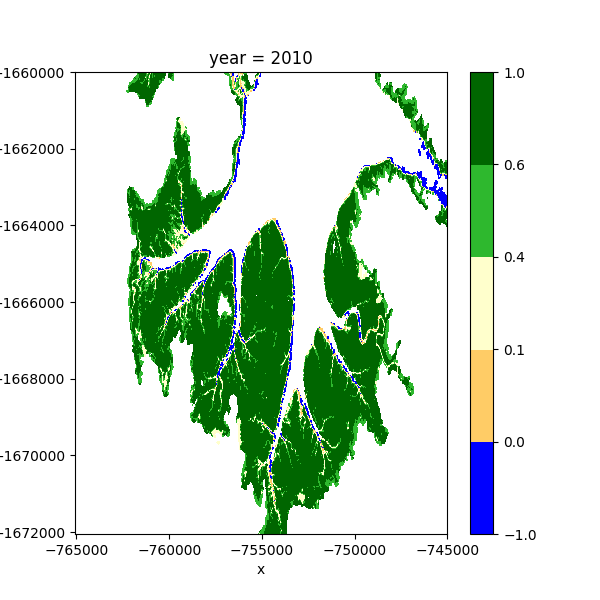

<IPython.core.display.Javascript object>


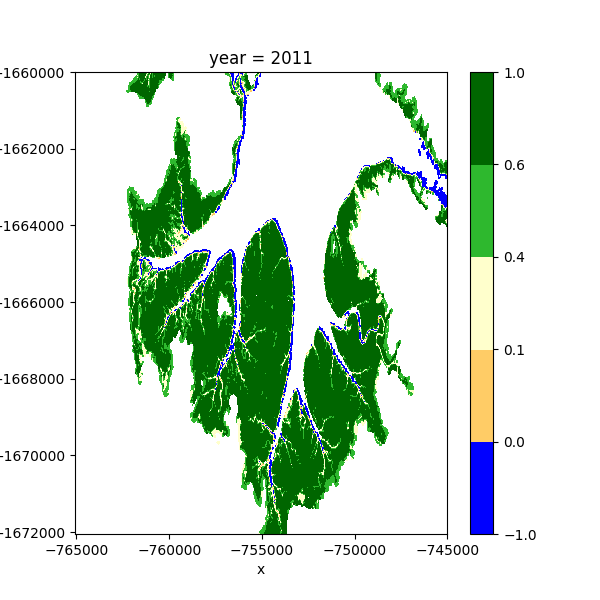

<IPython.core.display.Javascript object>


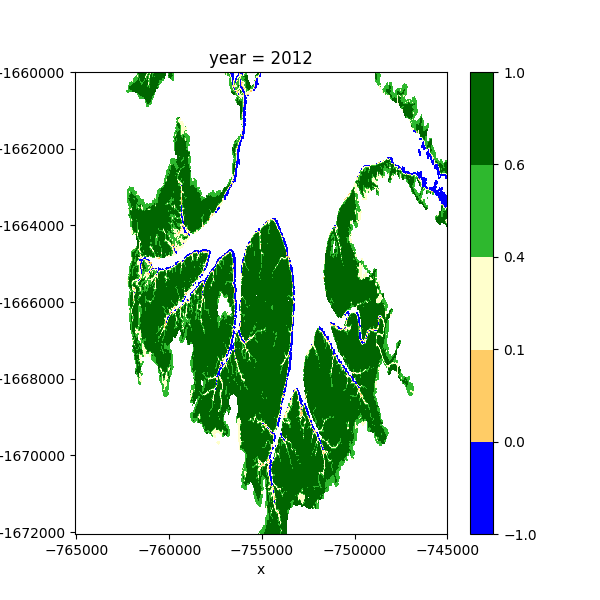

<IPython.core.display.Javascript object>


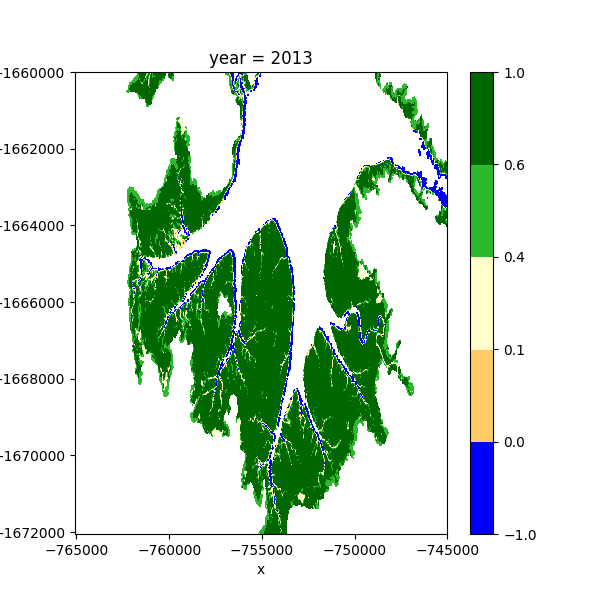

<IPython.core.display.Javascript object>


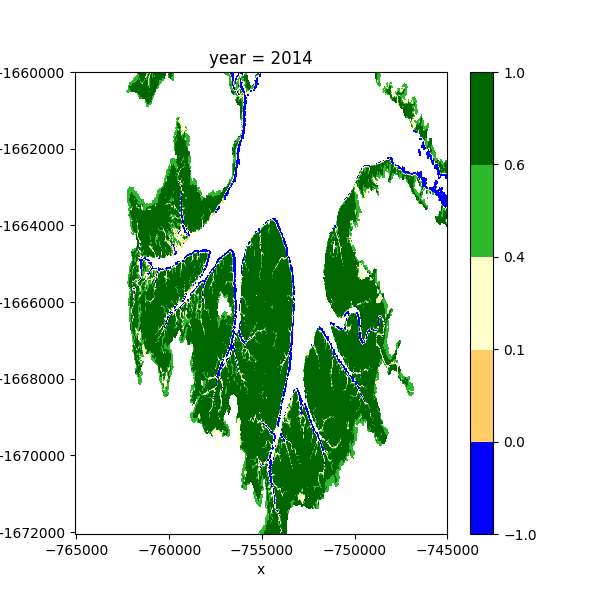

<IPython.core.display.Javascript object>


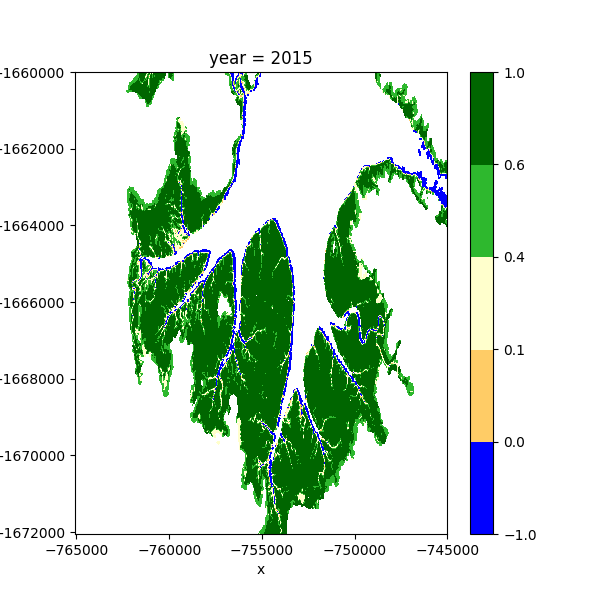

<IPython.core.display.Javascript object>


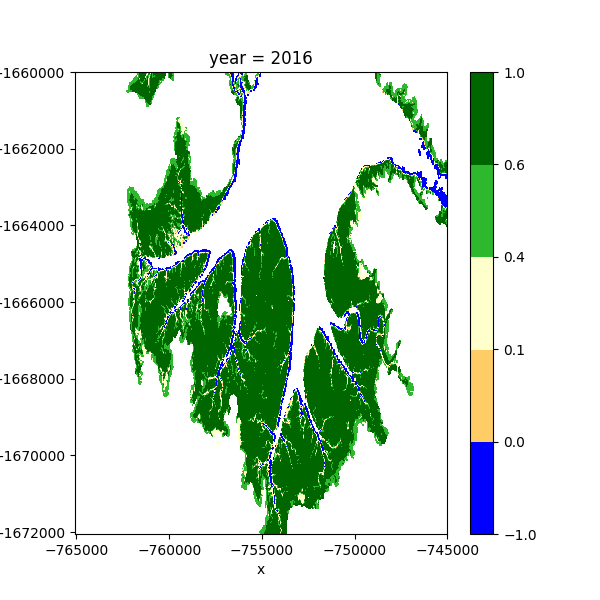

In [15]:


years = numpy.arange(2010, 2017)
for yoi in years:
    fig = plt.figure(figsize = (6,6))
    #yoi = 1987
    mangrove_multi.sel(year = yoi).plot(cmap = ndvi_cmap, norm = ndvi_norm)


In [16]:
man_area_py = mangrove_area.sum(dim = ['x','y'])

<IPython.core.display.Javascript object>


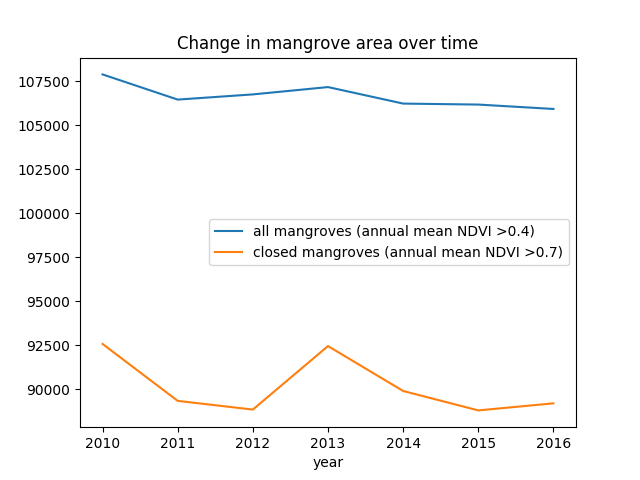

In [17]:
fig = plt.figure()
mangrove_area.sum(dim = ['x','y']).plot(label = 'all mangroves (annual mean NDVI >0.4)')
closed_mangrove_area.sum(dim = ['x','y']).plot(label = 'closed mangroves (annual mean NDVI >0.7)')
plt.title('Change in mangrove area over time')
plt.legend()

<IPython.core.display.Javascript object>


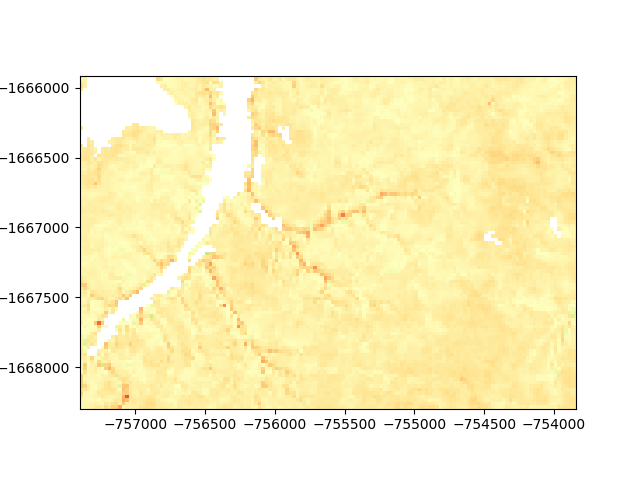

In [20]:
#Use this cell to compare change between any two years
fig = plt.figure()
#Define the year you wish to use as a reference point
ref_year = 2013
#Define the year you wish to use to detect change
change_year = 2016
nd_ref_year = mangrove_multi.sel(year = (ref_year))
nd_change_year = mangrove_multi.sel(year = (change_year))
nd_dif = nd_change_year - nd_ref_year
plt.imshow(nd_dif, cmap = 'RdYlGn', vmin = -0.3, vmax = 0.3, extent=[nd_dif.coords['x'].min(), nd_dif.coords['x'].max(), 
                   nd_dif.coords['y'].min(), nd_dif.coords['y'].max()])

<IPython.core.display.Javascript object>


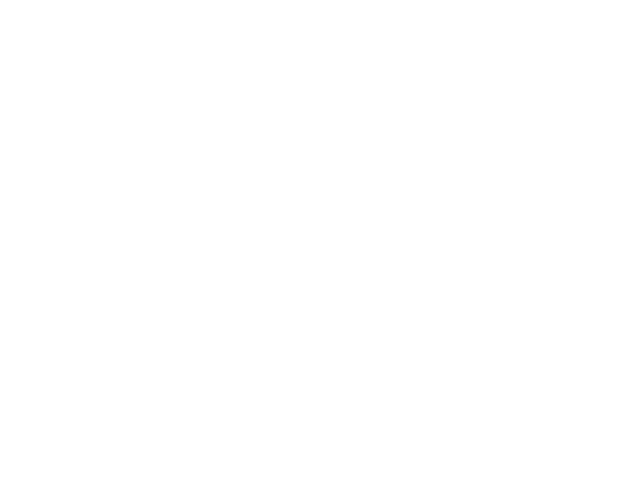

<IPython.core.display.Javascript object>


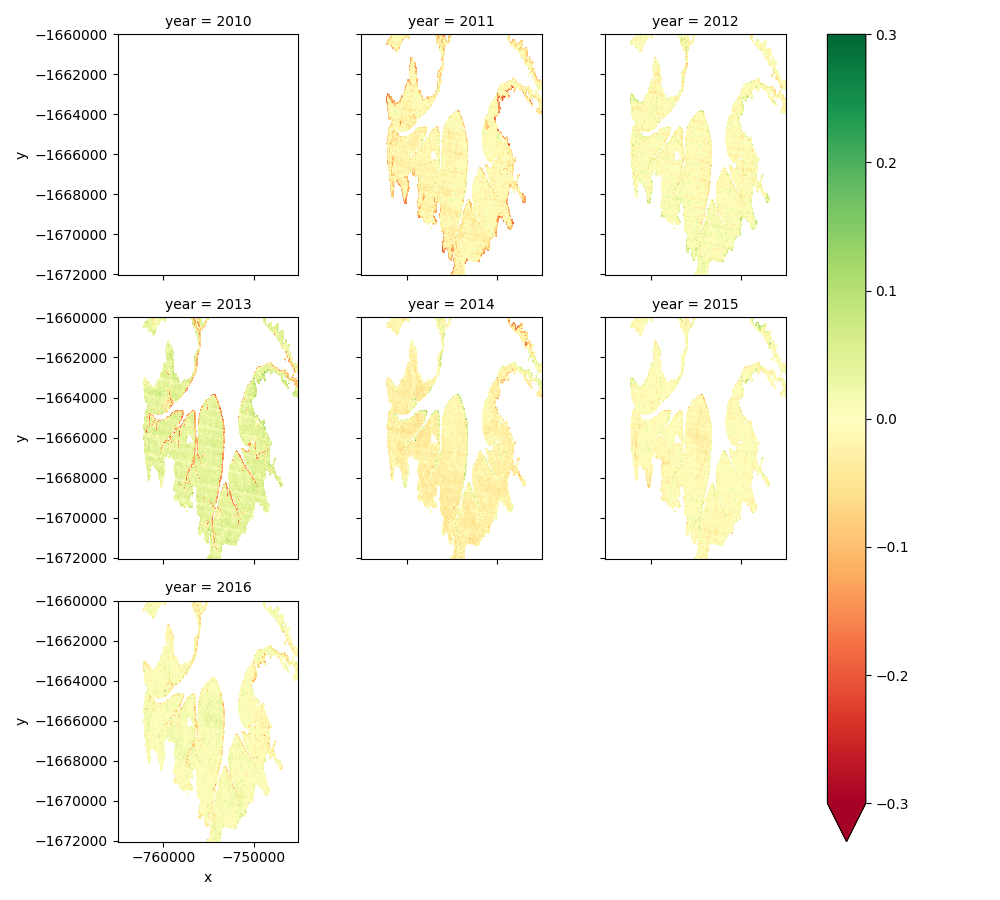

In [21]:
#This cell shows the change in mangrove extent between each year and the previous year
fig = plt.figure()

nd_dif2 = mangrove_multi-mangrove_multi.shift(year = +1) 
nd_dif2.plot(col = 'year', col_wrap = 3, cmap = 'RdYlGn', vmin = -0.3, vmax = 0.3)